# Satellite Land Cover trend assessment for Spatial Planning and Land Management

Production date: 20-12-2024

Produced by: Inês Girão e Luís Figueiredo (+ATLANTIC)

## 🌍 Use case: Using land cover products to quantify afforestation/deforestation trends

## ❓ Quality assessment question
* **Is the dataset accurate and consistent for the analysis of afforestation/deforestation trends in the Iberian Peninsula?**




Land Cover data is an invaluable resource for a wide range of fields, from climate change research to forest management. Land Cover products that provide historical timelines enable scientists, policymakers, and planners to understand and analyse the transformation of land cover over recent decades [[1]](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Forests,_forestry_and_logging)[[2]](https://commission.europa.eu/document/cf3294e1-8358-4c93-8de4-3e1503b95201_en).

This notebook will access the ***Land cover classification gridded maps from 1992 to present derived from satellite observations*** (henceforth, LC) data from the Climate Data Store (CDS) of the Copernicus Climate Change Service (C3S), and analyse the spatial patterns of a specific LC type over a given Area of Interest (AoI) and time.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* The dataset's spatial resolution provides adequate coverage for large-scale afforestation analysis. However, finer afforestation efforts, such as small reforested plots, may remain undetected.

* The dataset is updated annually, ensuring consistency across time. However, variations in satellite inputs and classification algorithms over the years may introduce minor inconsistencies in trend analysis, although not apparent in this analysis.

* No significant redefinitions of forest classes have been reported in the dataset or observed in the analysis, indicating strong consistency in land cover classification over time.

* Annual data is available without gaps from 1992 to the present, making the dataset suitable for long-term afforestation/deforestation trend studies.
```


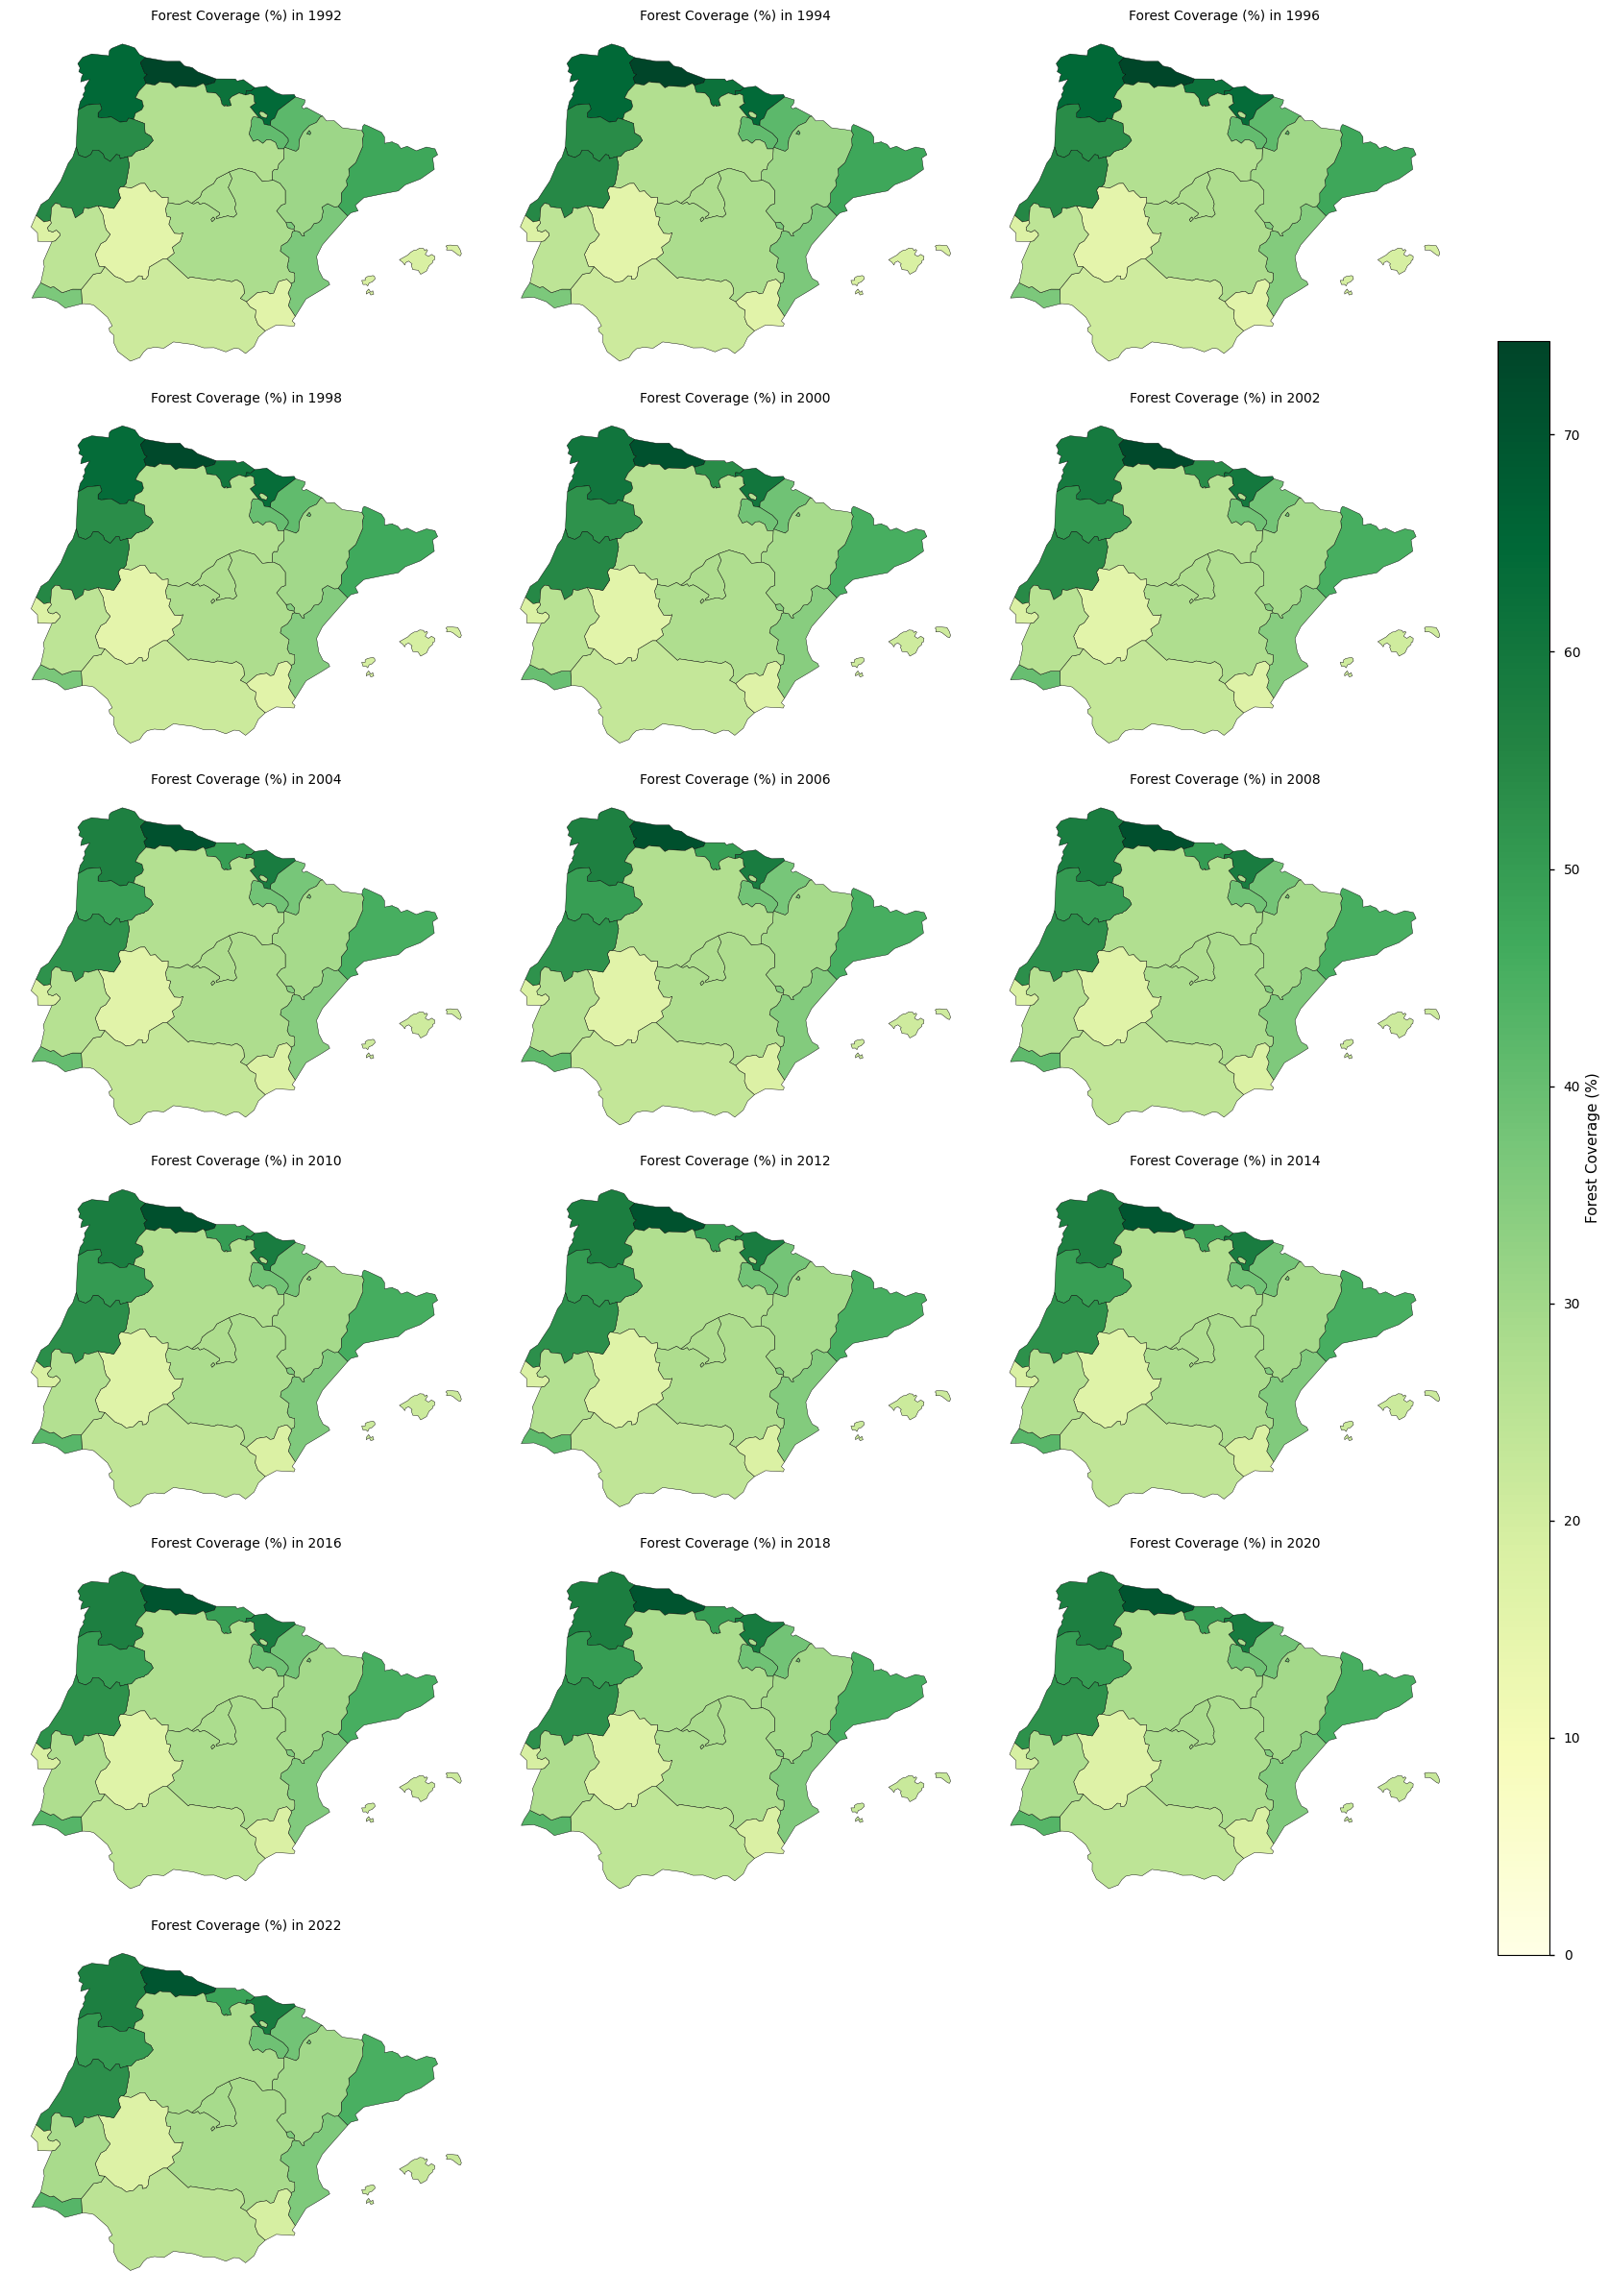

## 📋 Methodology

**This Use Case comprises the following steps:**

**[1. Define the AoI, search and download LC data](code-section-1)**

**[2. Inspect and view data for the defined AoI (Iberian Peninsula)](code-section-2)**

**[3. Analysing Temporal Trends](code-section-3)**

***[3.1 Map forest area coverage over-time by NUTS regions in the AoI](code-section-3.1)***

***[3.2. Plot trends by NUTS regions in the AoI](code-section-3.2)***

***[3.3 Map the slope in forest area and non-significant trends for the full time-period](code-section-3.3)***

**[4. Main Takeaways](code-section-4)**

## 📈 Analysis and results

(code-section-1)=
### 1. Define the AoI, search and download LC data.
Before we begin we must prepare our environment. This includes installing the Application Programming Interface (API) of the CDS, and importing the various python libraries that we will need.

#### Install CDS API
To install the CDS API, run the following command. We use an exclamation mark to pass the command to the shell (not to the Python interpreter).
If you already have the CDS API installed, you can skip or comment this step.

In [ ]:
!pip install cdsapi

##### Import all the libraries/packages

We will be working with data in NetCDF format. To best handle this type of data we will use libraries for working with multidimensional arrays, in particular Xarray. 
We will also need libraries for plotting and viewing data.

In [1]:
# Import packages
import pandas as pd
import geopandas as gpd # import vector geospatial data
import numpy as np 
import xarray as xr

import matplotlib.pyplot as plt # plot graphs
import matplotlib.colors as colors
from shapely.geometry import box
from shapely.geometry import Polygon
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.patches import Patch

import random

import dask
from scipy.stats import kendalltau, theilslopes

import regionmask # transform attributes and geometries into specific regions
from c3s_eqc_automatic_quality_control import download, plot, utils 

plt.style.use("seaborn-v0_8-notebook") # predefined style of all graphical outputs

##### Data Overview

To search for data, visit the CDS website: http://cds.climate.copernicus.eu. Here you can search for 'Satellite observations' using the search bar. The data we need for this tutorial is the ***Land cover classification gridded maps from 1992 to present derived from satellite observations***. This catalogue entry provides global Land Cover Classification (LCC) maps with a very high spatial resolution, with a L4 processing level, on an annual basis with a one-year delay, following the [Global Climate Observing System (GCOS) convention requirements](https://library.wmo.int/records/item/58111-the-2022-gcos-ecvs-requirements-gcos-245). LULC maps correspond to a global classification scheme, encompassing 22 classes.

The dataset consists of 2 versions (v2.0.7 produced by the European Space Agency (ESA) Climate Change Initiative (CCI) and v2.1.1 produced by Copernicus Climate Change Service (C3S)).

Data specifications for this use case:
* **Years:** 1992 to 2022 (bi-annual)
* **Version:** v2.0.7 before 1992 and v2.1.1 after 2016
* **Format:** Zip files

At the end of the download form, select “**Show API request**”. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook. Having copied the API request, running it will retrieve and download the data you requested into your local directory. However, before you run it, the **terms and conditions** of this particular dataset need to have been accepted directly at the CDS website. The option to view and accept these conditions is given at the end of the download form, just above the “**Show API request**” option. In addition, it is also useful to define the time period and AoI parameters and edit the request accordingly, as exemplified in the cells below.

In [2]:
#Years to download
years = [1992, 1994, 1996, 1998, 2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020, 2022]


In [3]:
# List of requests to retrieve data
collection_id = "satellite-land-cover"
requests = [
    {
        "variable": "all",
        "format": "zip",
        "version": "v2_0_7cds" if year < 2016 else "v2_1_1",
        "year": str(year),
        "area": [45, -10, 35, 4] # Region of interest (Iberian Peninsula)
    }
    for year in years
]

In [4]:
# Download and regionalize by AoI
ds = download.download_and_transform(
    collection_id,
    requests,
)
ds = ds.assign_coords(year=ds["time"].dt.year).swap_dims(time="year").drop("time")
 

100%|██████████| 16/16 [00:00<00:00, 155.29it/s]
/tmp/ipykernel_167464/1081004638.py:6: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = ds.assign_coords(year=ds["time"].dt.year).swap_dims(time="year").drop("time")


In [5]:
#Inspect the database
ds

<xarray.Dataset> Size: 4GB
Dimensions:              (year: 16, latitude: 3600, longitude: 5040, bounds: 2)
Coordinates:
    lat_bounds           (longitude, latitude, bounds) float64 290MB dask.array<chunksize=(1680, 1200, 1), meta=np.ndarray>
    lon_bounds           (longitude, bounds) float64 81kB dask.array<chunksize=(5040, 2), meta=np.ndarray>
    time_bounds          (longitude, year, bounds) datetime64[ns] 1MB dask.array<chunksize=(5040, 1, 2), meta=np.ndarray>
  * latitude             (latitude) float64 29kB 45.0 45.0 44.99 ... 35.0 35.0
  * longitude            (longitude) float64 40kB -9.999 -9.996 ... 3.996 3.999
  * year                 (year) int64 128B 1992 1994 1996 ... 2018 2020 2022
Dimensions without coordinates: bounds
Data variables:
    lccs_class           (year, latitude, longitude) uint8 290MB dask.array<chunksize=(1, 1800, 2520), meta=np.ndarray>
    processed_flag       (year, latitude, longitude) float32 1GB dask.array<chunksize=(1, 1800, 2520), meta=np.ndarray>
    current_pixel_state  (year, latitude, longitude) float32 1GB dask.array<chunksize=(1, 1800, 2520), meta=np.ndarray>
    observation_count    (year, latitude, longitude) uint16 581MB dask.array<chunksize=(1, 1800, 2520), meta=np.ndarray>
    change_count         (year, latitude, longitude) uint8 290MB dask.array<chunksize=(1, 1800, 2520), meta=np.ndarray>
    crs                  (year, longitude) int32 323kB dask.array<chunksize=(1, 5040), meta=np.ndarray>
Attributes: (12/38)
    id:                         ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992-v2.0.7cds
    title:                      Land Cover Map of ESA CCI brokered by CDS
    summary:                    This dataset characterizes the land cover of ...
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-landcover-cci.org/
    ...                         ...
    geospatial_lon_max:         180
    spatial_resolution:         300m
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.002778
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.002778

(code-section-2)=
### 2. Inspect and view data for the defined AoI (Iberian Peninsula)
#### Compute Land Cover classes area coverage for each NUTS 2 region

To further identify changes in LC patterns, in this user question, NUTS 2 will be used, providing the information reggarding the main regions/parcels of the Iberian Peninsula.

The NUTS are a hierarchical system divided into 3 levels (https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts). NUTS 1 correspond to major socio-economic regions, NUTS 2 correspond to basic regions for the application of regional policies, and NUTS 3 correpsond to small regions for specific diagnoses. Additionally a NUTS 0 level, usually co-incident with national boundaries is also available. The NUTS legislation is periodically amended; therefore multiple years are available for download. 


The step below masks the Land Cover data according to the NUTS 2 boundaries and calculate the area of each pixel (weighted by the cosine of Latitude). For each NUTS 2, we proceed with the analysis and visual inspection of Land Cover areas per class and corresponding percentages during the elected period.

#### Mask regions

First, we need to establish the geometry of the NUTS region (level 2) in order to make the corresponding statistics.

In [6]:
# Configure Dask
dask.config.set(scheduler='threads', **{'array.slicing.split_large_chunks': True})

# Define CRS and bounding box for Iberian Peninsula
crs_wgs84 = "EPSG:4326"
iberian_bbox = box(-10, 36, 3.5, 44)

# Load and filter GeoDataFrame
shapefile_url = "https://gisco-services.ec.europa.eu/distribution/v2/nuts/shp/NUTS_RG_20M_2021_4326.shp.zip"
gdf = gpd.read_file(shapefile_url)
gdf = gdf[gdf["LEVL_CODE"] == 2]
gdf = gdf[gdf["NUTS_ID"].str.startswith(("ES", "PT"))]  # Spain (ES) and Portugal (PT)
gdf = gdf.to_crs(crs_wgs84)
gdf = gdf[gdf.intersects(iberian_bbox)]
gdf = gdf[gdf.geometry.is_valid & ~gdf.geometry.is_empty]

if gdf.empty:
    raise ValueError("No valid geometries found after filtering.")

# Ensure dataset CRS is set
if ds.rio.crs is None:
    ds = ds.rio.write_crs("EPSG:4326", inplace=True)

# Ensure dataset coordinates overlap with the filtered regions
filtered_lon_min, filtered_lat_min, filtered_lon_max, filtered_lat_max = gdf.total_bounds
if (
    ds["longitude"].min().values > filtered_lon_max
    or ds["longitude"].max().values < filtered_lon_min
    or ds["latitude"].min().values > filtered_lat_max
    or ds["latitude"].max().values < filtered_lat_min
):
    raise ValueError(
        "Dataset coordinates do not overlap with the filtered regions. Check dataset and region alignment."
    )

# Subset dataset to valid ranges
ds = ds.sel(
    longitude=slice(
        max(filtered_lon_min, ds["longitude"].min().values),
        min(filtered_lon_max, ds["longitude"].max().values)
    ),
    latitude=slice(
        min(filtered_lat_max, ds["latitude"].max().values),
        max(filtered_lat_min, ds["latitude"].min().values)
    )
)

# Check subsetted dataset dimensions
if ds["longitude"].size == 0 or ds["latitude"].size == 0:
    raise ValueError("Subsetting resulted in an empty dataset. Check the bounds and ensure overlap.")

# Create the regionmask
regions = regionmask.from_geopandas(gdf, names="NUTS_NAME")

# Create a 2D mask
mask = regions.mask(ds["longitude"], ds["latitude"])

ds= ds.where(mask.notnull(), drop=True)


#### Compute cell area

Then, we can calculate the area of each pixel taking into consideration the curvature of the earth (i.e., weighted by the cosine of Latitude).

In [7]:
# Scaling factor for conversion (constant longitude resolution)
scaling_factor = 0.002778  # Degrees
resolution_lon_km = scaling_factor * 111.195  # Longitude resolution in kilometers

# Use the latitude values directly from the dataset
lats = ds["latitude"]

# Calculate the difference between consecutive latitude values
lat_diff = np.abs(np.diff(lats.values))  # Absolute differences
lat_diff = np.append(lat_diff, lat_diff[-1])  # Assume the last cell has the same size as the one before

# Convert latitude differences to kilometers
resolution_lat_km = lat_diff * 111.195  # Latitude-dependent resolution

# Compute the grid cell area for each latitude
grid_cell_area = resolution_lon_km * resolution_lat_km * np.cos(np.radians(lats))

# Assign attributes to the grid cell area
grid_cell_area.attrs = {
    "standard_name": "cell_area",
    "long_name": "Grid cell area",
    "units": "km²",
}

# Add the grid cell area as a coordinate to the dataset
ds = ds.assign_coords(cell_area=("latitude", grid_cell_area.data))  # Use `.data` to extract the array



#### Select Forest Classes and Prepare Dataset

In [8]:
# Define forest classes
forest_classes = [50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90, 100, 160, 170]

# Create a mask for forested areas
forest_mask = ds['lccs_class'].isin(forest_classes)

# Masked forest area using cell area
ds_forest_area = ds['cell_area'].where(forest_mask)

# Stack latitude and longitude into a single dimension
ds_forest_area = ds_forest_area.stack(stacked_lat_lon=("latitude", "longitude"))

# Create a stacked mask and align dimensions
stacked_mask = mask.stack(stacked_lat_lon=("latitude", "longitude"))
stacked_mask.name = "stacked_mask"

# Attach the stacked mask to the dataset
ds_forest_area = ds_forest_area.assign_coords(stacked_mask=stacked_mask)

# Group by regions and compute forested area for each year
forest_area_by_region = (
    ds_forest_area.groupby("stacked_mask")
    .sum(dim="stacked_lat_lon")
    .compute()
)

#### Map Forest Pixel Coverage

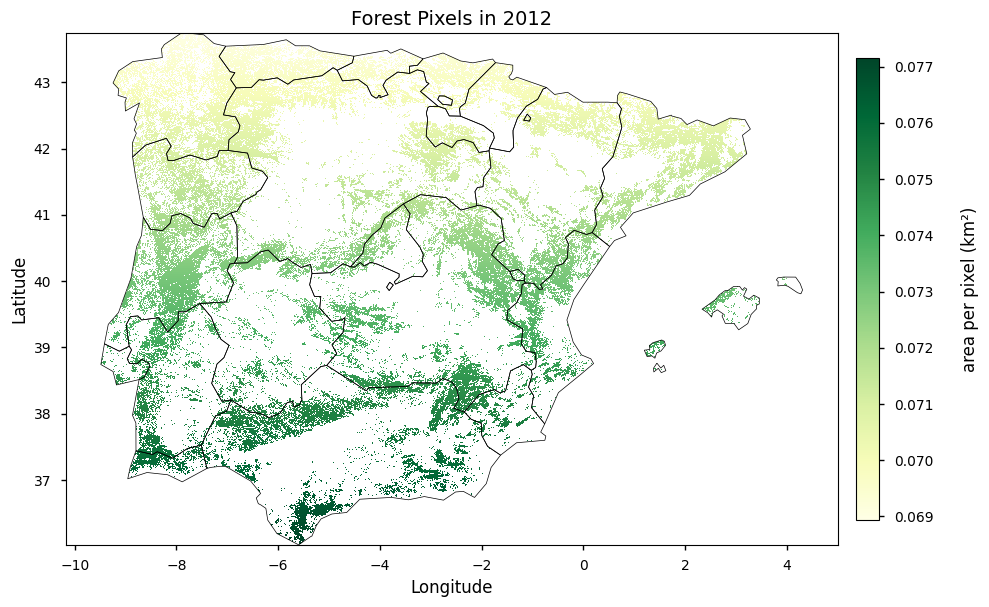

In [9]:
# Randomly select a year from the dataset
years = ds['year'].values  # Use 'year' instead of 'time'
random_year = random.choice(years)

# Subset the forest area data for the random year
forest_area_year = ds_forest_area.sel(year=random_year).unstack('stacked_lat_lon')

# Create a mask for non-zero forest area cells
forest_mask = ~np.isnan(forest_area_year)

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Add shapefile geometries from the GeoDataFrame to the plot
gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5)

# Plot the forest area for the selected year as squares
longitude, latitude = np.meshgrid(ds["longitude"], ds["latitude"])
ur_area = forest_area_year.values

# Mask non-forest areas
ur_area_masked = np.ma.masked_invalid(ur_area)
ur_plot = ax.pcolormesh(
    longitude, latitude, ur_area_masked, cmap="YlGn", shading="auto", edgecolors=None
)

# Set plot title and labels
ax.set_title(f"Forest Pixels in {random_year}", fontsize=14)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Add a colorbar to indicate forest area (in km²)
cbar = plt.colorbar(ur_plot, ax=ax, orientation="vertical", shrink=0.6, pad=0.02)
cbar.set_label("area per pixel (km²)", fontsize=12, labelpad=20)

# Display the plot
plt.show()


(code-section-3)=
### 3. Analysing Temporal Trends
#### Evaluating the direction and magnitude of changes over time

We employ the Mann-Kendall trend test to identify potential trends within time-series data, focusing on examining whether there exists a statistically significant increase or decrease in forest areas over the years. A positive Mann-Kendall test result indicates an upward trend, suggesting an increase in forest area over time, while a negative result signals a downward trend, indicating a reduction in forest area. If the test yields a statistically significant result (commonly p-value < 0.05), it implies that the observed trend is unlikely to be due to random variation and is likely reflective of a true underlying trend.

Complementing the Mann-Kendall test, the Theil-Sen estimator provides a robust non-parametric method to estimate the slope of the trend of the time series. The magnitude of the slope indicates the rate of change: a positive slope implies an increase in forest, while a negative slope suggests a decrease. The Theil-Sen estimator is particularly useful because it provides a reliable estimate of the median rate of change, even in the presence of outliers or non-normal data.

Interpreting these two tests together offers deeper insight: the Mann-Kendall test tells us whether there is a trend and the direction of that trend, while the Theil-Sen estimator quantifies how fast the forest is occurring (or declining). This combination allows for a comprehensive understanding of the trend's direction and its rate of change, providing robust evidence for forest patterns over time.

#### Compute trends by region

In [10]:
results = []
growth = {}

for reg, reg_area in forest_area_by_region.groupby("stacked_mask"):
    if np.isnan(reg):  # Skip NaN regions
        continue

    # Ensure valid region indexing and naming
    region_name = regions[int(reg)].name
    years = ds_forest_area['year'].values
    values = reg_area.values.flatten()  # Flatten in case of higher-dimensional arrays

    # Save growth data by year
    if len(values) > 0:
        growth[region_name] = {int(year): float(value) for year, value in zip(years, values)}
    else:
        growth[region_name] = {}  # Handle regions with no data

    # Calculate temporal trends (slope, tau, and p-value)
    if len(values) > 1:  # Ensure enough data points for statistical calculations
        tau, p_value = kendalltau(years, values)
        th_slope, intercept, _, _ = theilslopes(values, years)
    else:
        tau, p_value, th_slope = np.nan, np.nan, np.nan

    # Add results to the list
    for year, value in zip(years, values):
        results.append({
            "Region": region_name,
            "Year": int(year),
            "Forest_Area": float(value),
            "Slope": th_slope,
            "Tau": tau,
            "P_Value": p_value
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Add geometry to results_df
if 'NUTS_NAME' in gdf.columns:
    results_df = pd.merge(results_df, gdf[['NUTS_NAME', 'geometry']], left_on="Region", right_on="NUTS_NAME", how="left")
else:
    print("Warning: NUTS_NAME column not found in gdf.")

# Ensure results_df is a GeoDataFrame
if not isinstance(results_df, gpd.GeoDataFrame):
    results_df = gpd.GeoDataFrame(results_df, geometry=gpd.GeoSeries(results_df['geometry']), crs="EPSG:4326")

# Step 1: Reproject the GeoDataFrame to a projected CRS (EPSG:3035 is a good choice for Europe)
results_df = results_df.to_crs("EPSG:3035")

# Step 2: Calculate the total area of each region (in square kilometers)
results_df["Total_Area"] = results_df.geometry.area / 10**6  # Convert from m² to km²

(code-section-3.1)=
### 3.1 Map forest area coverage over-time by NUTS regions in the AoI

#### Map biennially forest area percentage in the AoI regions

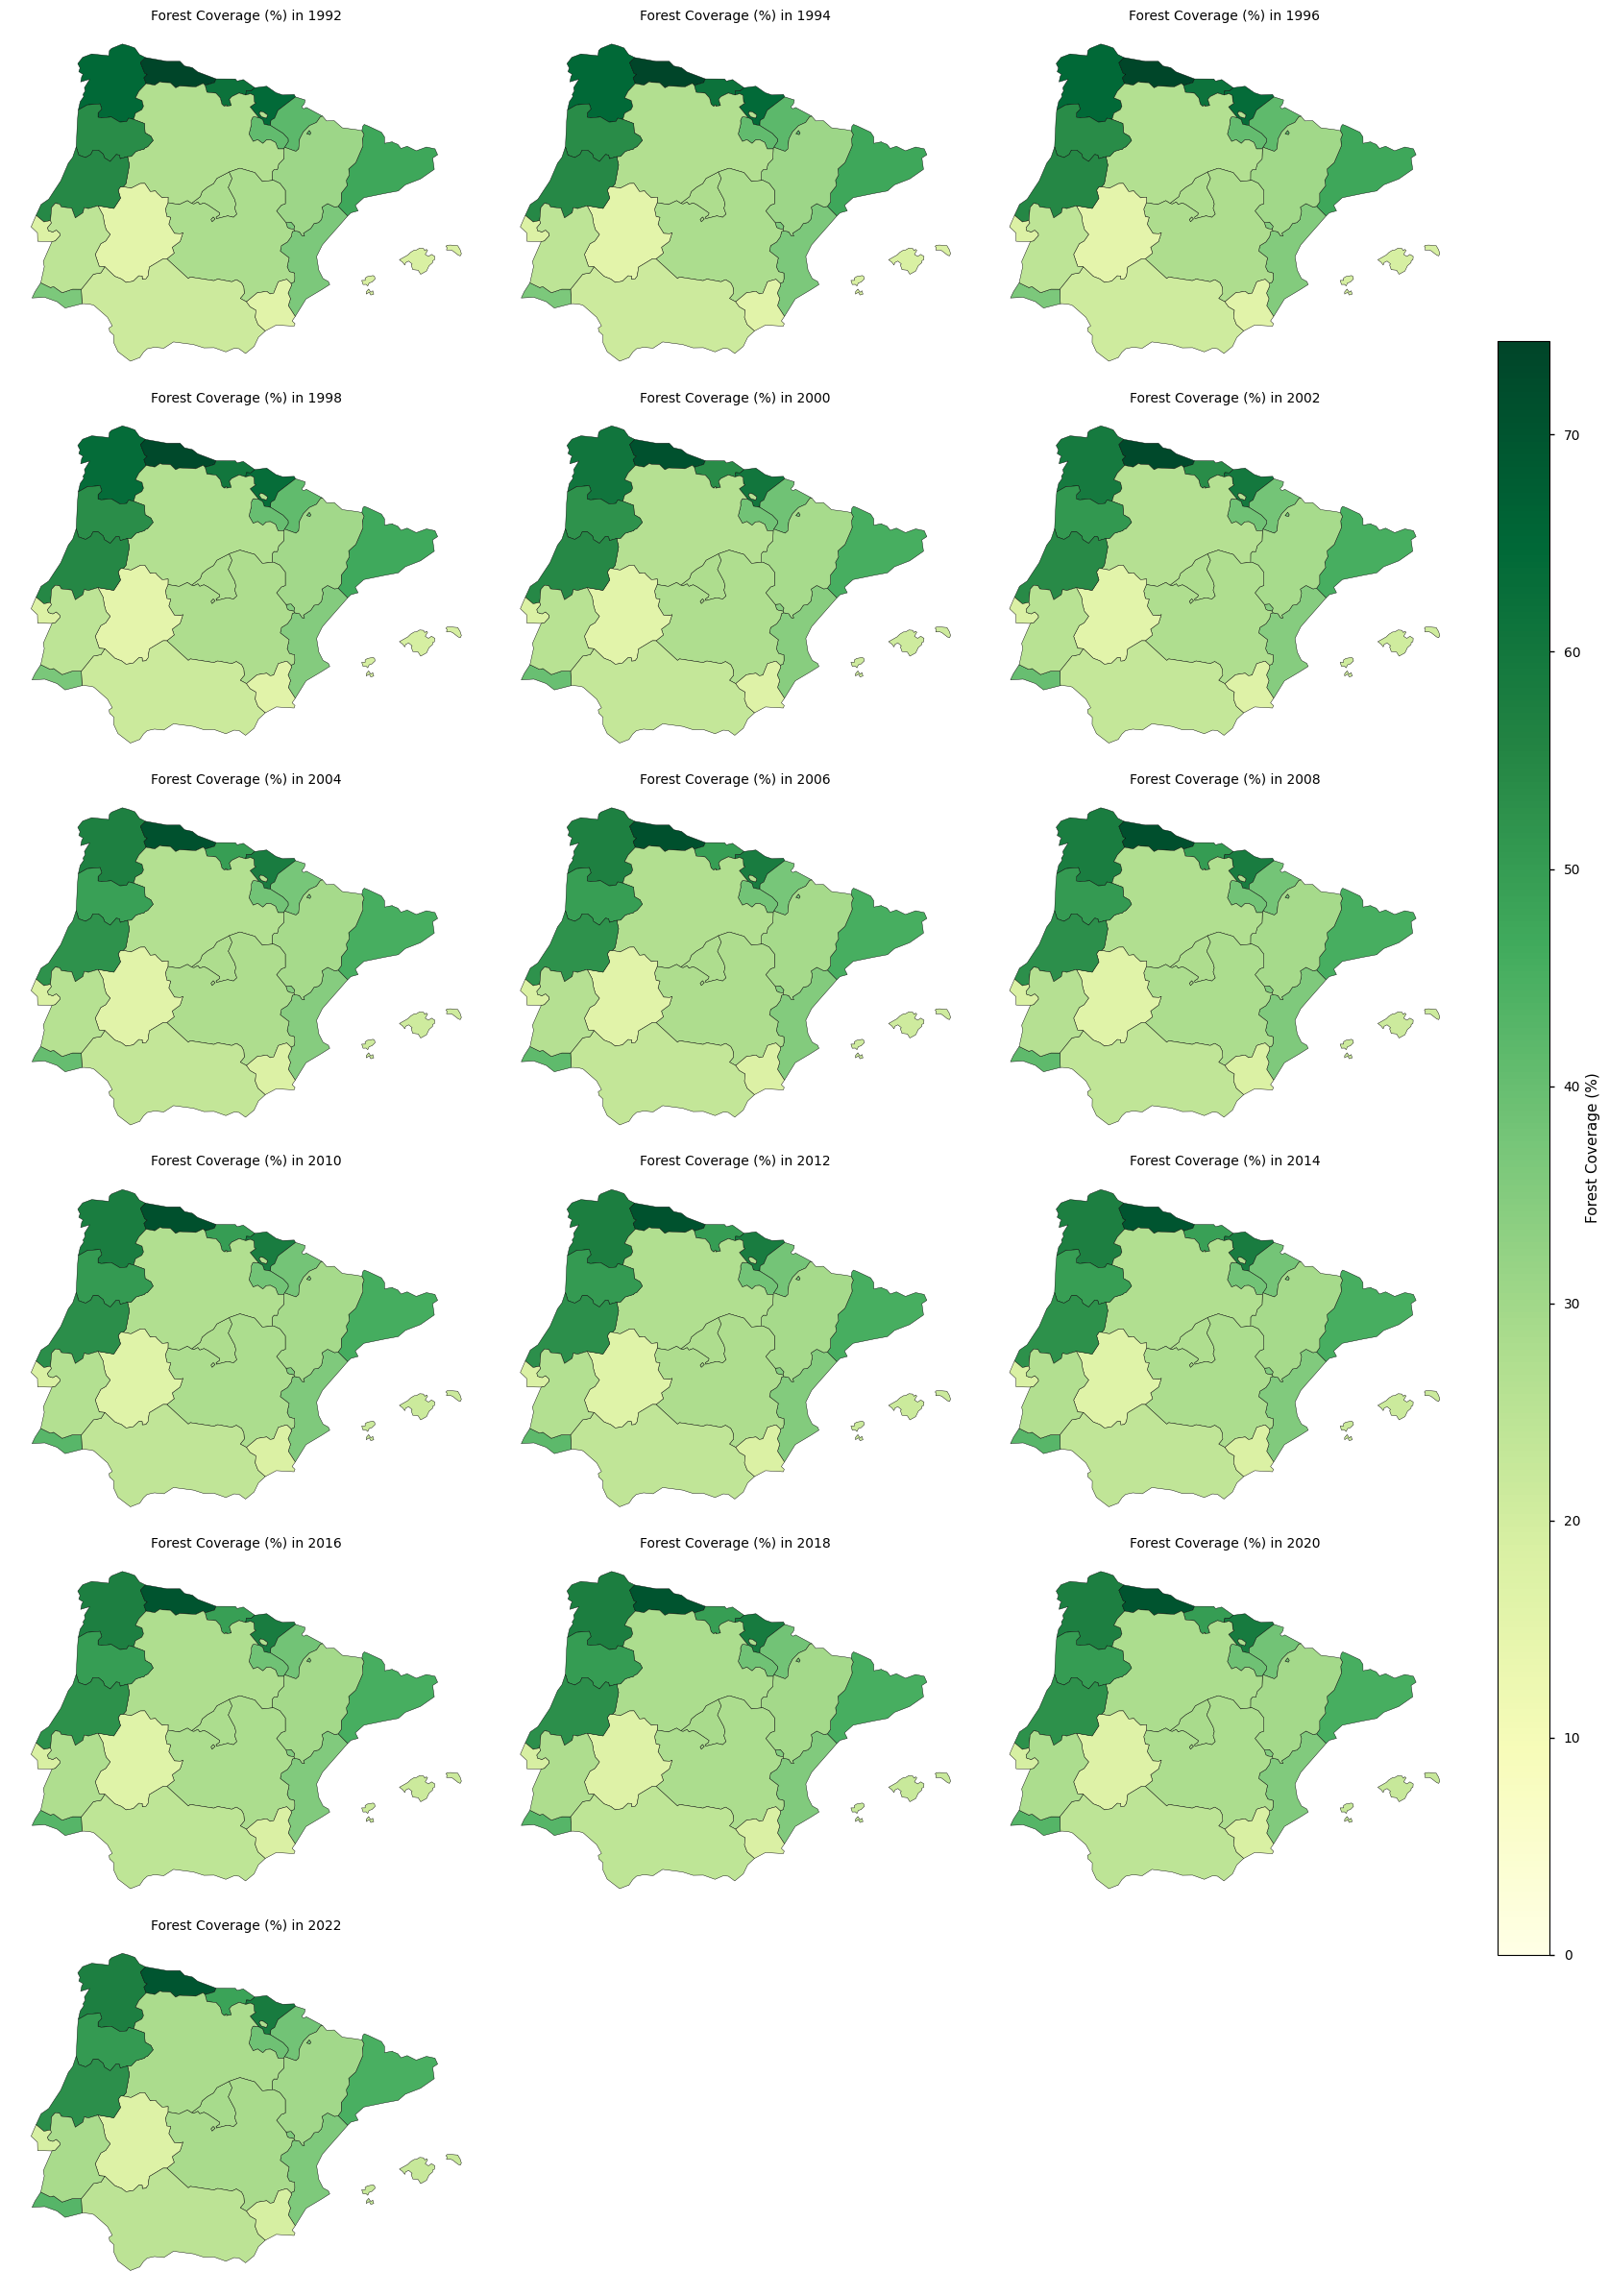

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize

# Ensure 'Year' is converted to string if needed
results_df['Year'] = results_df['Year'].astype(str)

#Calculate Forest Percentage
results_df['Forest_Percentage'] = (results_df['Forest_Area'] / results_df['Total_Area']) * 100

# Pivot the data to have years as columns
forest_pivot = results_df.pivot(index='Region', columns='Year', values='Forest_Percentage').reset_index()

# Extract years for plotting
years = [col for col in forest_pivot.columns if col.isdigit()]

# Normalize color scale across all maps based on percentage coverage
norm_percentage = Normalize(vmin=0, vmax=results_df['Forest_Percentage'].max())

# Plot settings
n_cols = 3
n_rows = int(np.ceil(len(years) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4), squeeze=False)

# Plot each year in a separate subplot
for idx, year in enumerate(years):
    row, col = divmod(idx, n_cols)
    ax = axes[row, col]
    results_df_year = results_df[results_df['Year'] == year]
    results_df_year.plot(column='Forest_Percentage', cmap="YlGn", ax=ax, edgecolor="k", norm=norm_percentage)
    ax.set_title(f"Forest Coverage (%) in {year}", fontsize=10)
    ax.axis('off')

# Hide unused subplots
for idx in range(len(years), n_rows * n_cols):
    row, col = divmod(idx, n_cols)
    axes[row, col].axis('off')

# Step 8: Adjust layout
plt.tight_layout()

# Allocate space for the color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])  # Create a new axes for color bar

# Create a single ScalarMappable object for the common colorbar
sm_common = plt.cm.ScalarMappable(cmap="YlGn", norm=norm_percentage)
sm_common._A = []  # Dummy array for the scalar mappable
fig.colorbar(sm_common, cax=cbar_ax, label="Forest Coverage (%)")

plt.show()


#### Map biennially forest area change

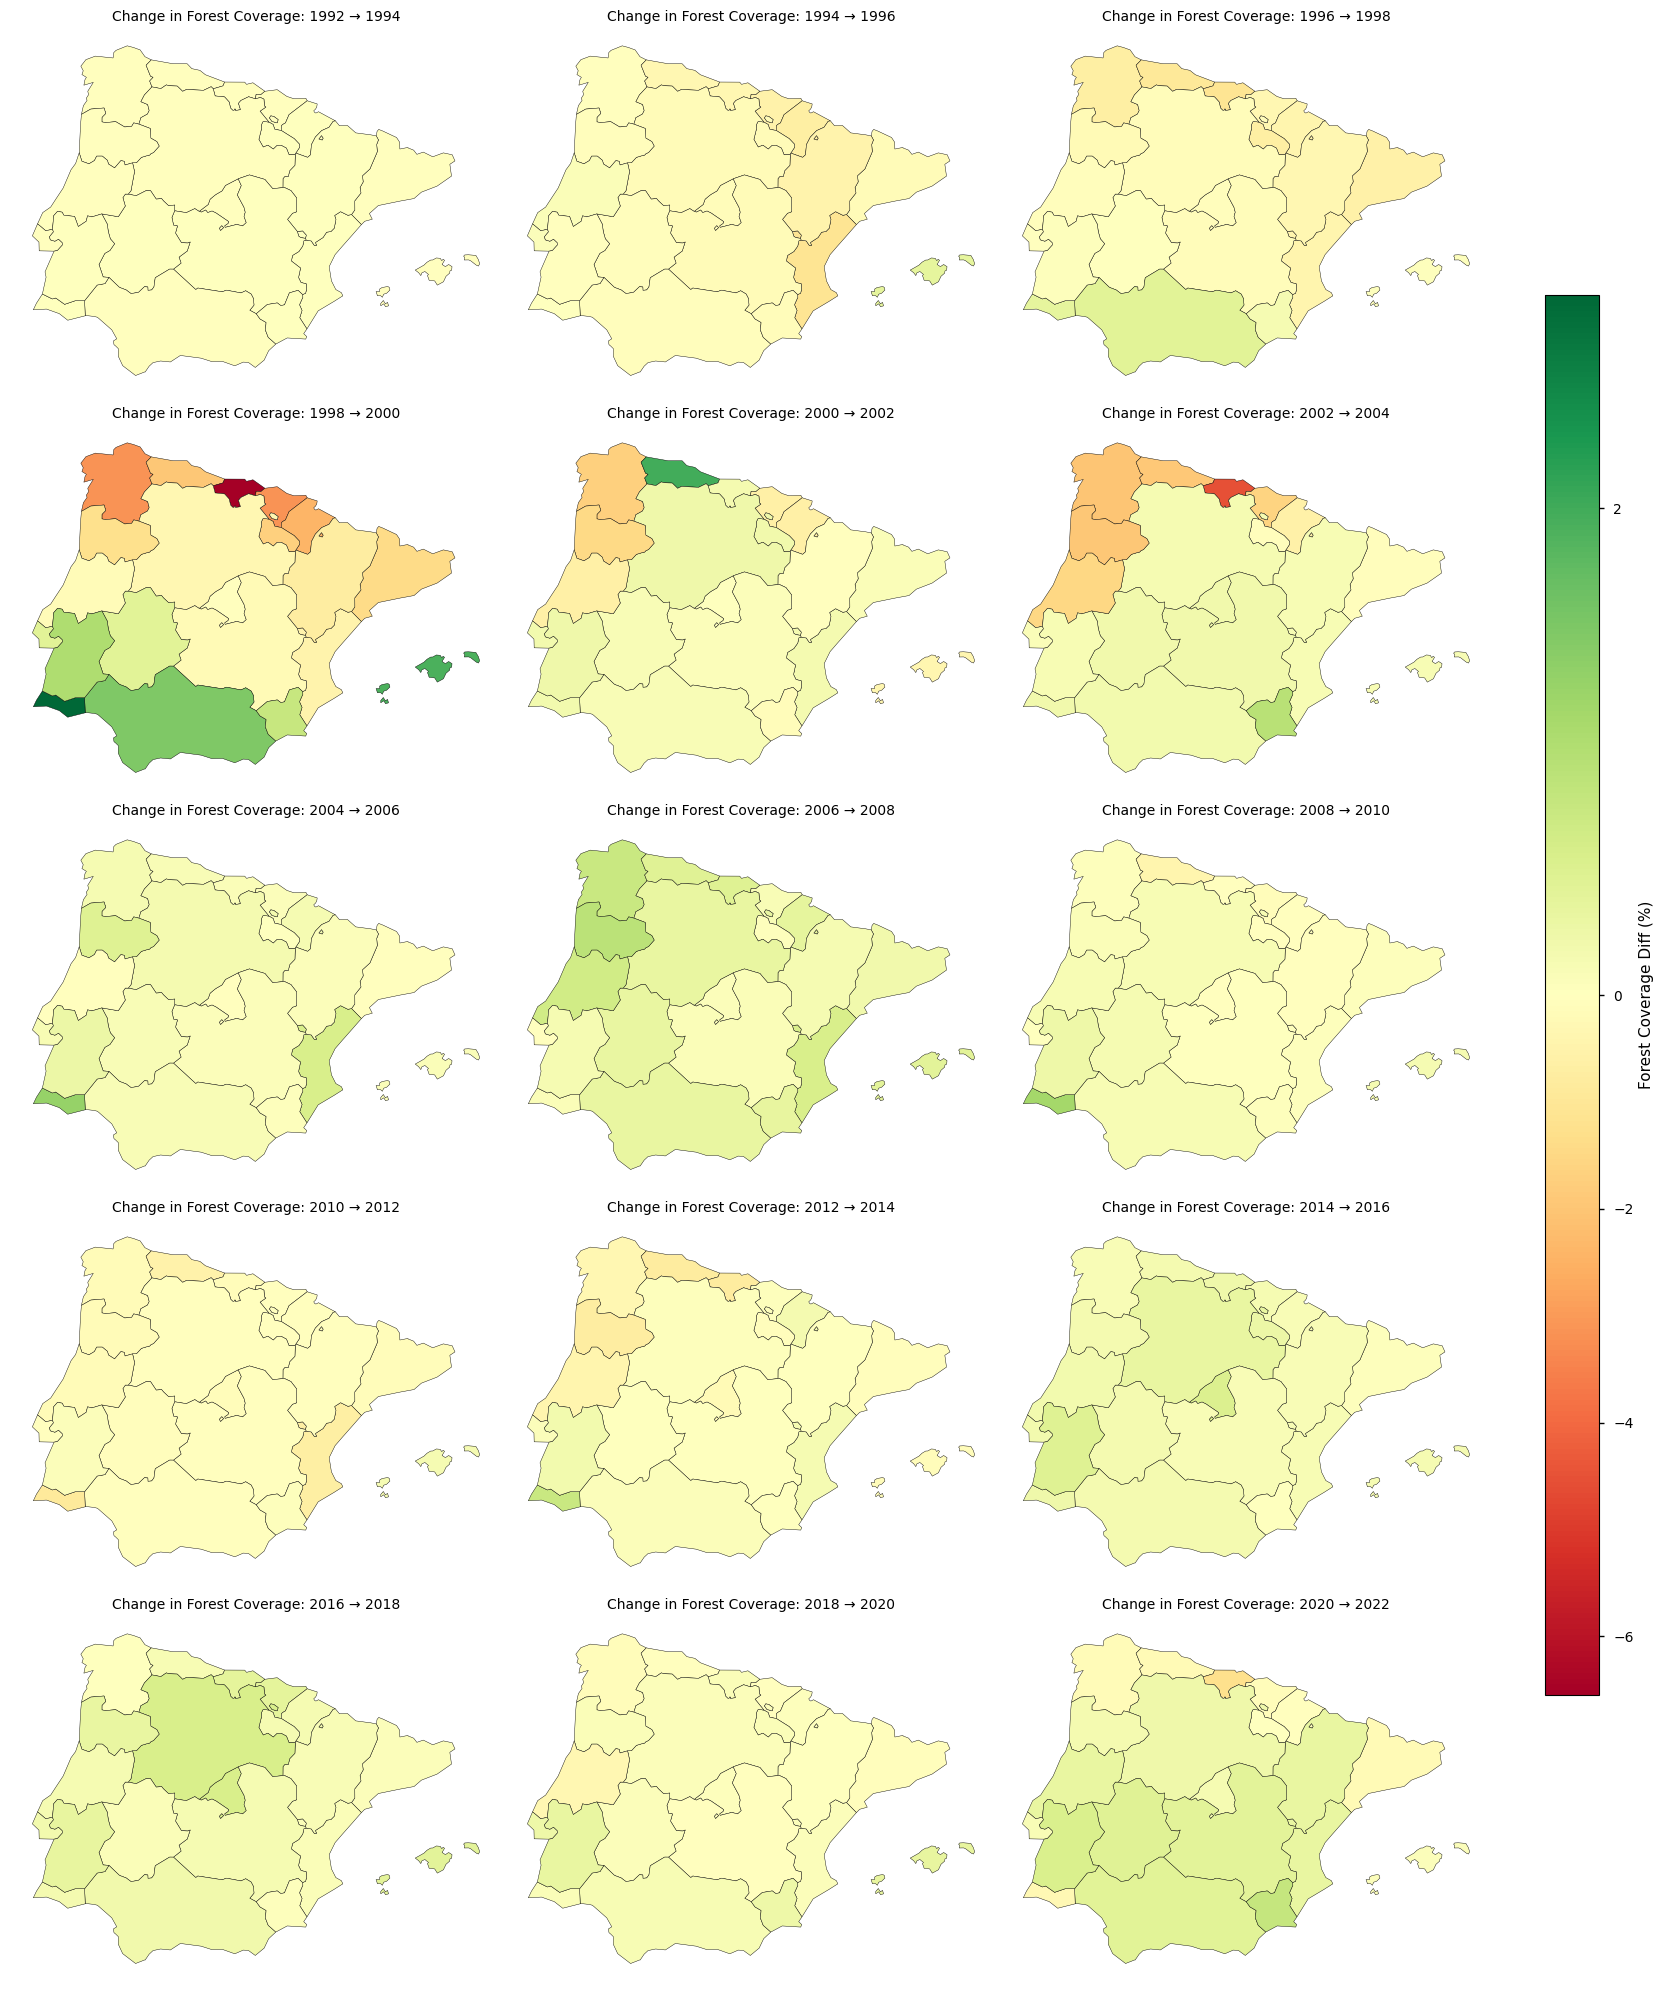

In [12]:
# Calculate the year-over-year percentage differences for each region
results_df['Forest_Percentage_Diff'] = results_df.groupby('Region')['Forest_Percentage'].diff()

# Automatically exclude the first year
first_year = int(results_df['Year'].min())  # Ensure the first year is an integer
filtered_years = sorted(results_df['Year'].astype(int).unique())  # Ensure years are integers
filtered_years = [year for year in filtered_years if year != first_year]  # Exclude the first year

# Normalize color scale around zero (e.g., -6 to +6 with 0 as neutral)
norm_diff = TwoSlopeNorm(vmin=results_df['Forest_Percentage_Diff'].min(), vcenter=0, vmax=results_df['Forest_Percentage_Diff'].max())

# Plot settings
n_cols = 3
n_rows = int(np.ceil(len(filtered_years) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4), squeeze=False)

# Improved color scale: Diverging with neutral at zero
cmap = "RdYlGn"

# Plot each year in a separate subplot
for idx, year in enumerate(filtered_years):
    row, col = divmod(idx, n_cols)
    ax = axes[row, col]
    results_df_year = results_df[results_df['Year'].astype(int) == year]
    previous_year = year - 2  # Ensure year is treated as an integer
    results_df_year.plot(column='Forest_Percentage_Diff', cmap=cmap, ax=ax, edgecolor="k", norm=norm_diff)
    ax.set_title(f"Change in Forest Coverage: {previous_year} → {year}", fontsize=10)
    ax.axis('off')

# Hide unused subplots
for idx in range(len(filtered_years), n_rows * n_cols):
    row, col = divmod(idx, n_cols)
    axes[row, col].axis('off')

# Adjust layout
plt.tight_layout()

# Allocate space for the color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])  # Create a new axes for the color bar

# Create a single ScalarMappable object for the common colorbar
sm_common = plt.cm.ScalarMappable(cmap=cmap, norm=norm_diff)
sm_common._A = []  # Dummy array for the scalar mappable
fig.colorbar(sm_common, cax=cbar_ax, label="Forest Coverage Diff (%)")

plt.show()




#### Map Analysis

**How to interpret:** 

* The forest coverage percentage for each year is calculated as the proportion of forest land area relative to the total land area for each region. This calculation provides a standardized measure of the extent of afforestation/deforestation, allowing for direct comparisons across regions and over time.

* The biennially difference in forest coverage percentage is calculated by subtracting the forest coverage percentage of the previous year from that of the current year for each region. This calculation provides a measure of change, highlighting increases or decreases in forest coverage over time.

**Analysis:** 
* Over the 28-year period, all regions show small changes in forest area coverage.
* Principado de Asturias, Cantabria, País Vasco, Galicia, Centro (PT)consistently stand out with the highest levels of forest coverage, as evidenced by its strong green and yellow colors throughout the maps. 

(code-section-3.2)=
### 3.2 Plot trends by NUTS regions in the AoI

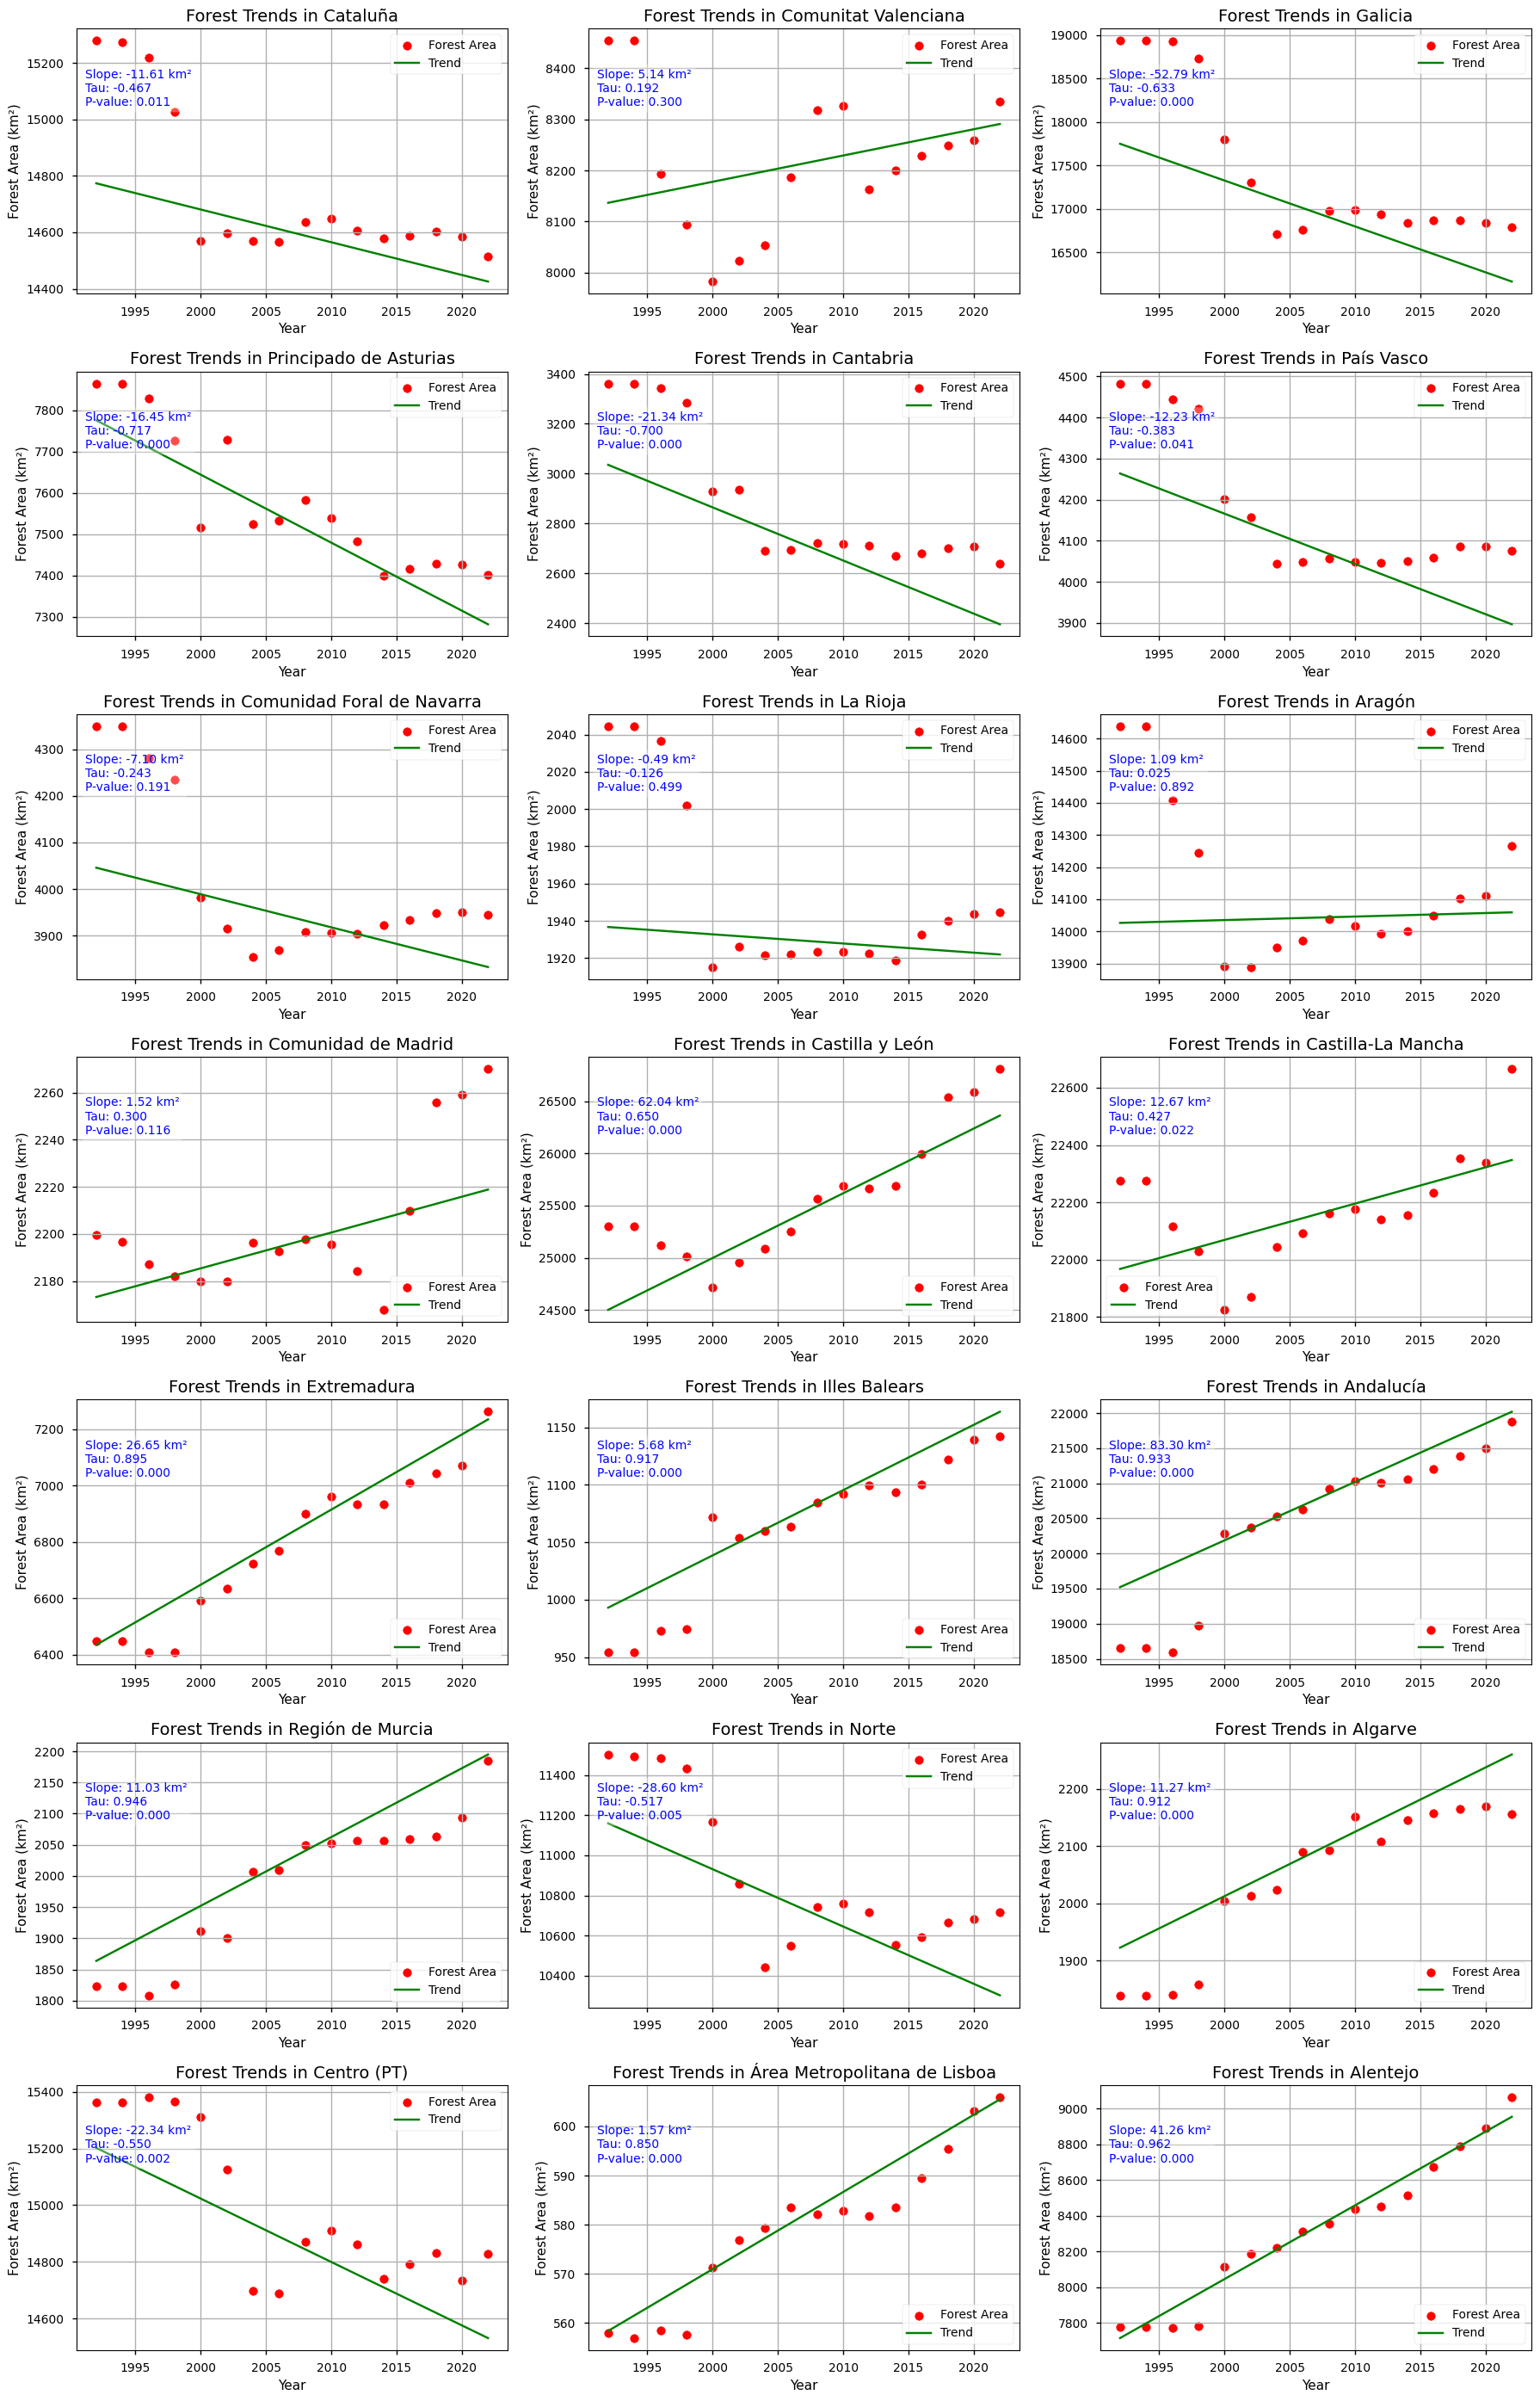

In [13]:
# Ensure years are numeric
results_df["Year"] = results_df["Year"].astype(int)

# Plotting all regions
unique_regions = results_df["Region"].unique()
n_cols = 3
n_rows = int(np.ceil(len(unique_regions) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))
axes = axes.flatten()

for idx, region in enumerate(unique_regions):
    ax = axes[idx]
    region_data = results_df[results_df["Region"] == region]
    years = region_data["Year"].values.astype(float)  # Ensure years are floats
    forest_area = region_data["Forest_Area"].values

    # Trend analysis
    tau, p_value = kendalltau(years, forest_area)
    th_slope, intercept, _, _ = theilslopes(forest_area, years)

    # Plot data and trend line
    ax.scatter(years, forest_area, color='r', label='Forest Area')
    ax.plot(years, th_slope * years + intercept, color='g', label=f'Trend')

    # Customize plot
    ax.set_title(f"Forest Trends in {region}", fontsize=14)
    ax.set_xlabel("Year")
    ax.set_ylabel("Forest Area (km²)")
    ax.legend()
    ax.grid()

    # Add tau and p-value inside the plot
    ax.text(
        0.02, 0.85, 
        f"Slope: {th_slope:.2f} km²\nTau: {tau:.3f}\nP-value: {p_value:.3f}",
        transform=ax.transAxes, fontsize=10, color="blue", 
        verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.3, color="white")
    )

# Hide unused subplots
for idx in range(len(unique_regions), len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout()
plt.show()


#### Plot the regions with the highest slope (positive or negative)

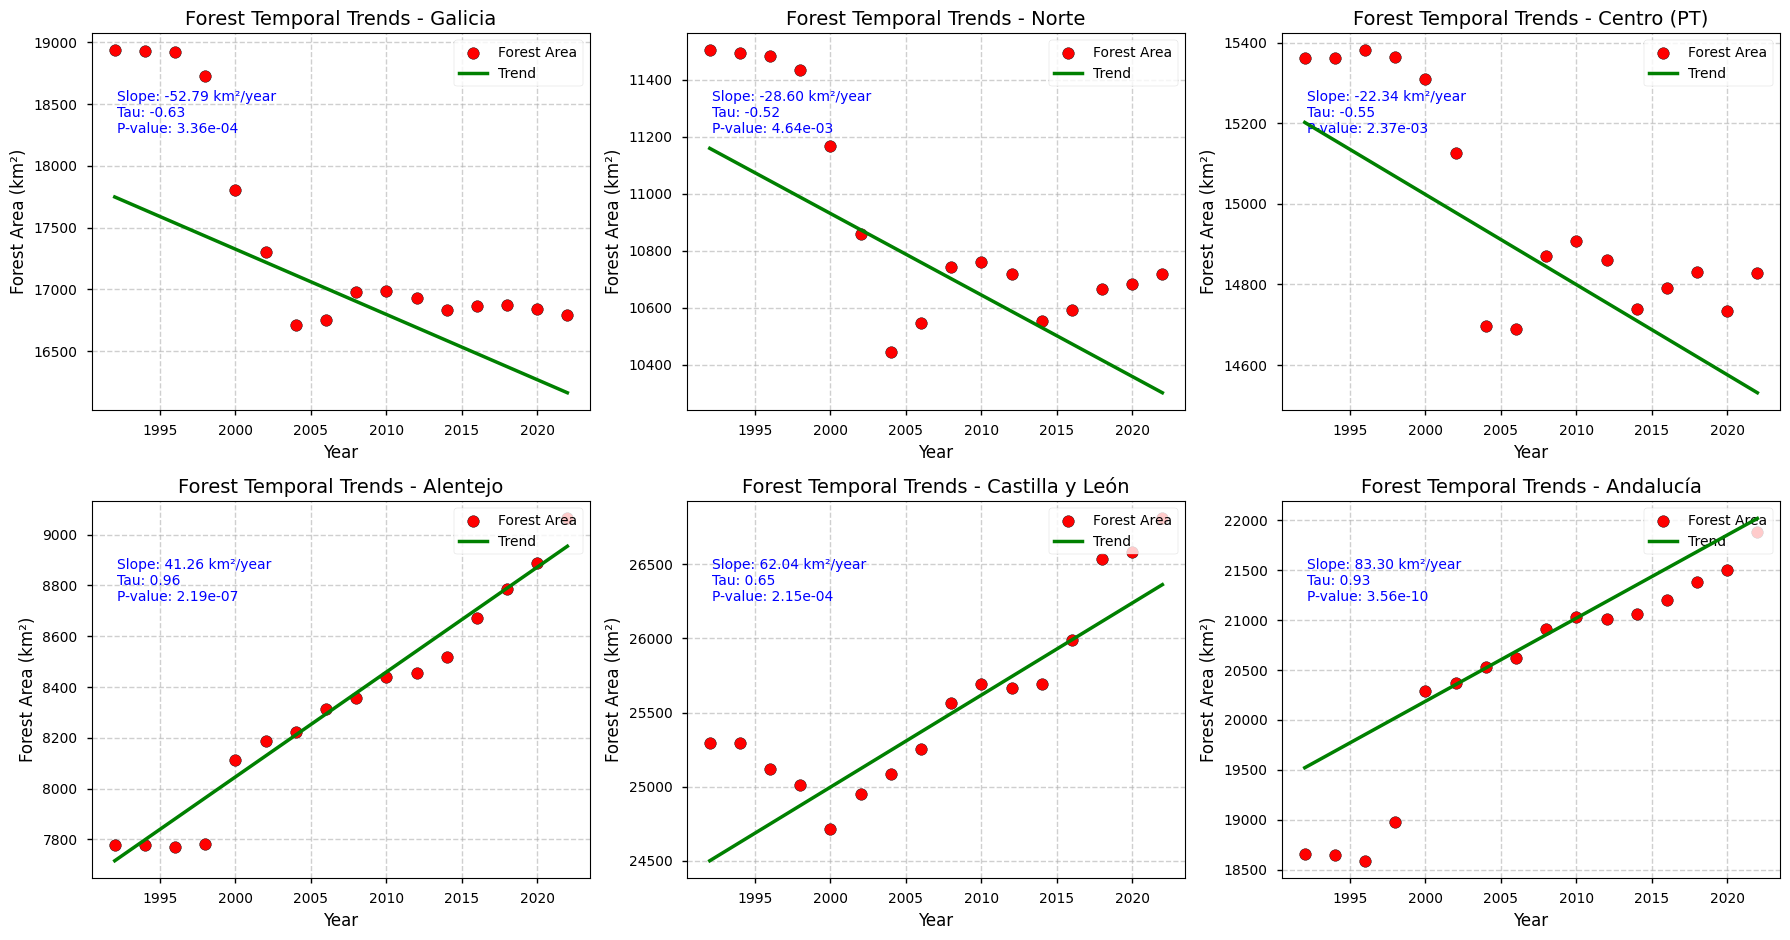

In [14]:
# Select top and bottom regions by slope directly from the results_df
sorted_regions = results_df.groupby("Region")["Slope"].mean().sort_values()
bottom_regions = sorted_regions.head(3)  # Bottom 3 regions with the lowest negative slopes
top_regions = sorted_regions.tail(3)  # Top 3 regions with the highest positive slopes
selected_regions = bottom_regions.index.tolist() + top_regions.index.tolist()

# Plot settings for consistency
fig, axes = plt.subplots(2, 3, figsize=(18, 10), squeeze=False)  # 2 rows, 3 columns
axes = axes.flatten()

# Iterate over selected regions
for idx, region in enumerate(selected_regions):
    region_data = results_df[results_df["Region"] == region]
    years = region_data["Year"].values
    values = region_data["Forest_Area"].values
    
    # Calculate trend line and statistics
    tau, p_value = kendalltau(years, values)
    th_slope, intercept, _, _ = theilslopes(values, years)

    # Scatter plot and trend line
    axes[idx].scatter(years, values, label="Forest Area", color="red", s=70, marker="o", edgecolor="black", zorder=5)
    axes[idx].plot(years, th_slope * years + intercept, color="green", linewidth=2.5, linestyle="-", label="Trend", zorder=10)

    # Titles and labels
    axes[idx].set_title(f"Forest Temporal Trends - {region}", fontsize=14)
    axes[idx].set_xlabel("Year", fontsize=12)
    axes[idx].set_ylabel("Forest Area (km²)", fontsize=12)
    axes[idx].grid(True, linestyle="--", alpha=0.6)

    # Add slope and statistical information inside the plot
    axes[idx].text(
        0.05, 0.85, f"Slope: {th_slope:.2f} km²/year\nTau: {tau:.2f}\nP-value: {p_value:.2e}",
        fontsize=10, color="blue", transform=axes[idx].transAxes, ha="left", va="top"
    )

    # Legend
    axes[idx].legend(loc="upper right", fontsize=10)

# Hide unused subplots if fewer than 6 regions
for idx in range(len(selected_regions), len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



#### Plot bar-charts of biennially forest area percentage and forest percentage difference

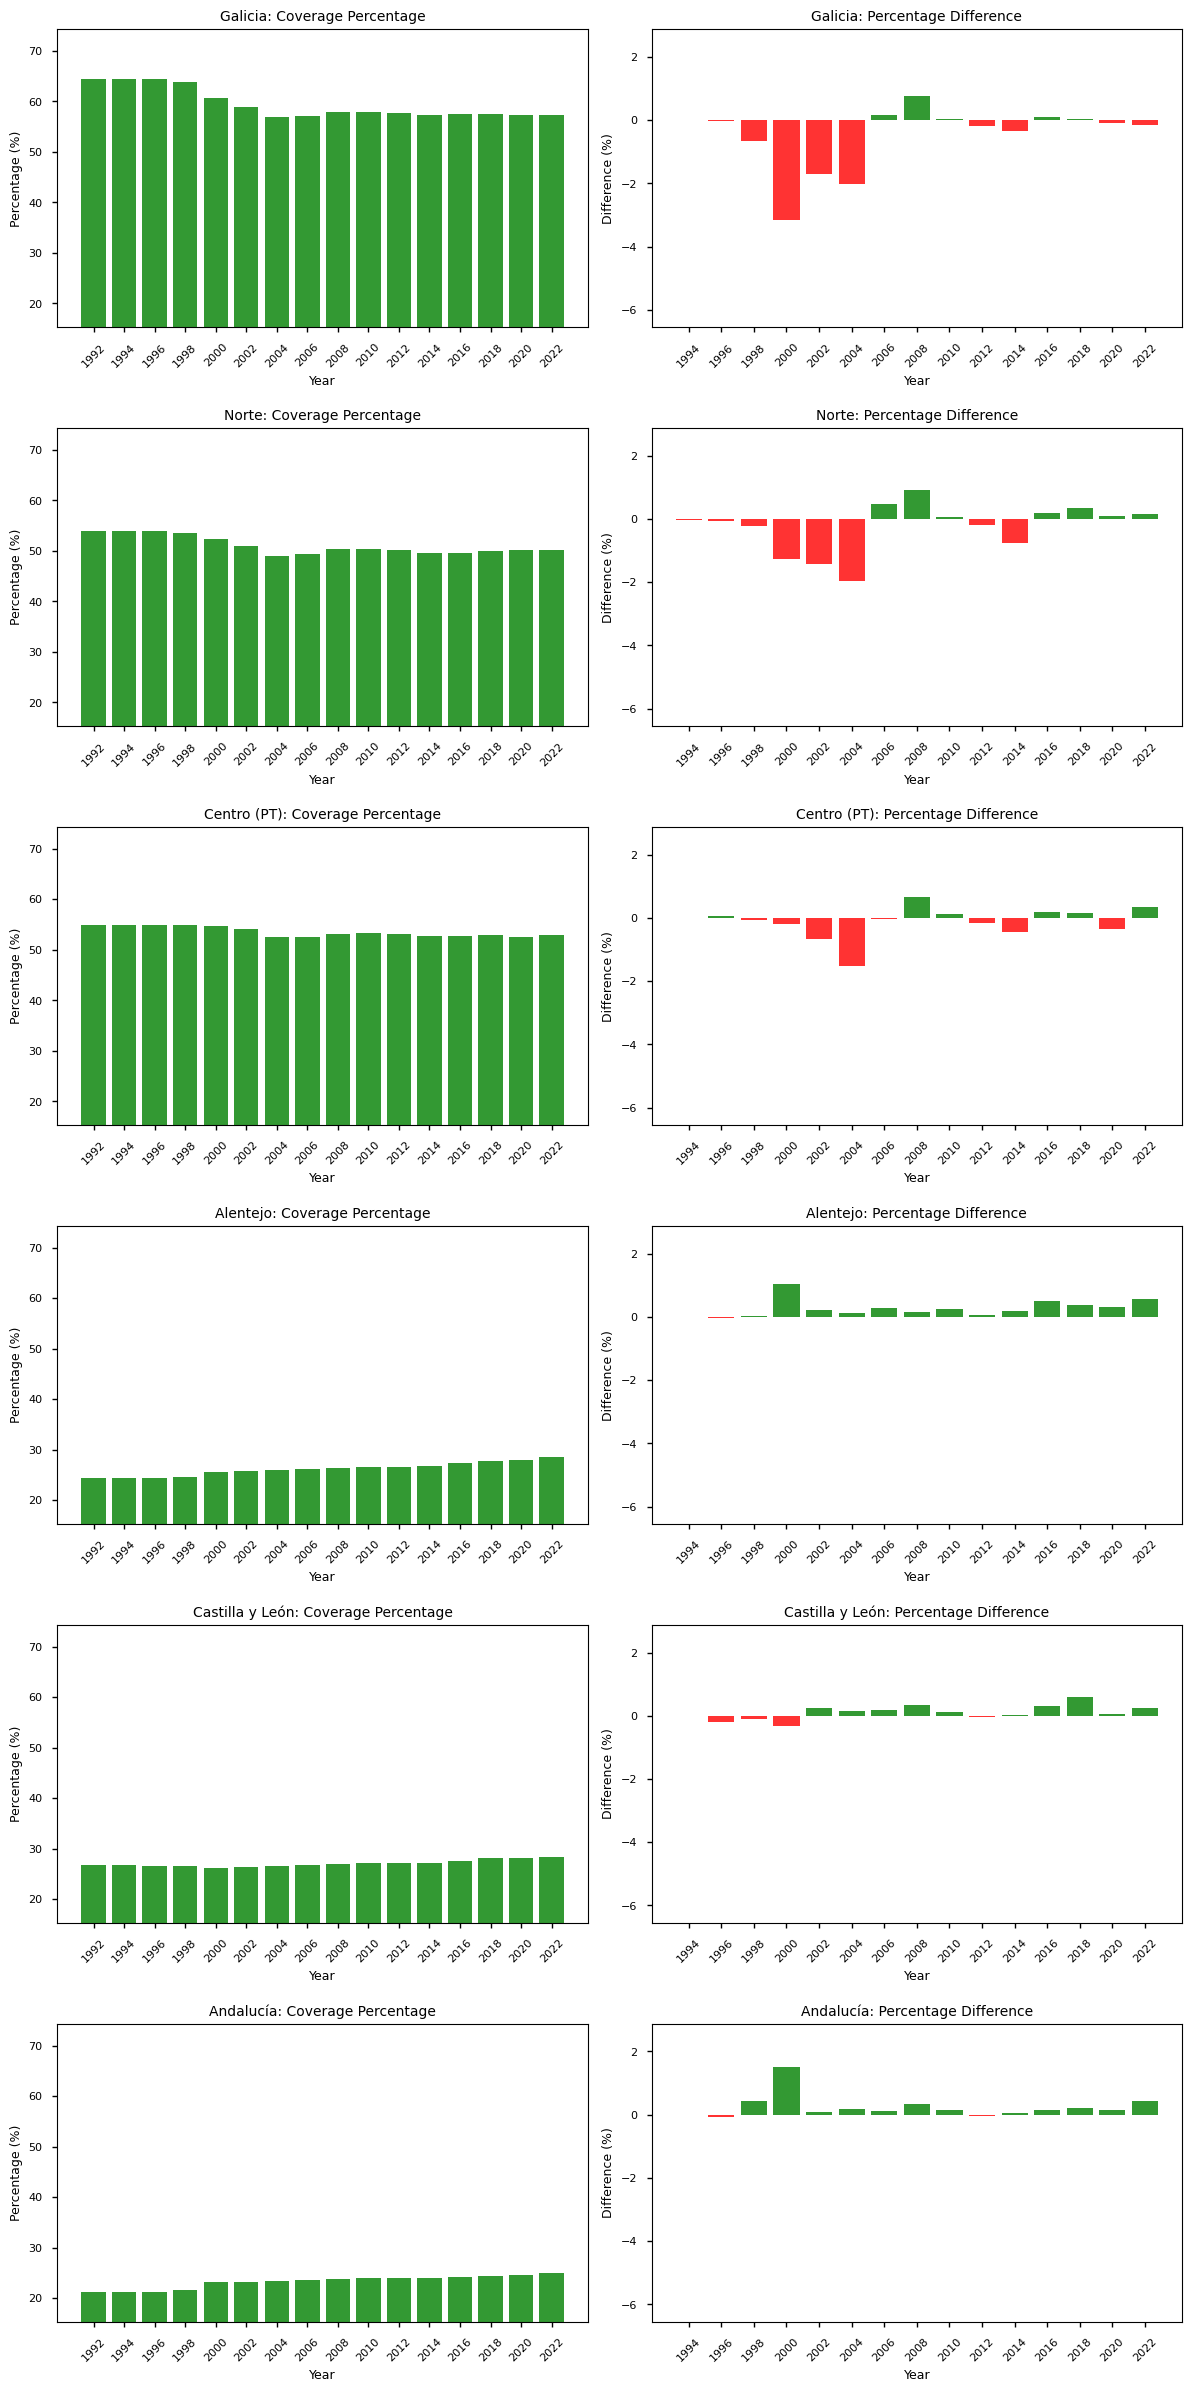

In [18]:

# Get global y-axis limits for all plots
coverage_min = results_df['Forest_Percentage'].min()
coverage_max = results_df['Forest_Percentage'].max()
diff_min = results_df['Forest_Percentage_Diff'].min()
diff_max = results_df['Forest_Percentage_Diff'].max()

# Plot the graphs for each region
num_regions = len(selected_regions)
fig, axes = plt.subplots(nrows=num_regions, ncols=2, figsize=(12, 4 * num_regions))  # Adjusted figure size

# Loop through each selected region
for idx, region in enumerate(selected_regions):
    region_data = results_df[results_df['Region'] == region].sort_values('Year')
    years = region_data['Year'].astype(str).tolist()
    percentages = region_data['Forest_Percentage'].values
    percentage_diff = region_data['Forest_Percentage_Diff'].values

    # Plot coverage percentage
    axes[idx, 0].bar(years, percentages, alpha=0.8, color='green')
    axes[idx, 0].set_title(f'{region}: Coverage Percentage', fontsize=10)
    axes[idx, 0].set_xlabel('Year', fontsize=9)
    axes[idx, 0].set_ylabel('Percentage (%)', fontsize=9)
    axes[idx, 0].set_ylim(coverage_min, coverage_max)  # Consistent y-axis limits
    axes[idx, 0].tick_params(axis='x', rotation=45, labelsize=8)
    axes[idx, 0].tick_params(axis='y', labelsize=8)

    # Plot percentage difference
    bar_colors_diff = ['green' if diff > 0 else 'red' for diff in percentage_diff[1:]]  # Skip first NaN difference
    axes[idx, 1].bar(years[1:], percentage_diff[1:], alpha=0.8, color=bar_colors_diff)
    axes[idx, 1].set_title(f'{region}: Percentage Difference', fontsize=10)
    axes[idx, 1].set_xlabel('Year', fontsize=9)
    axes[idx, 1].set_ylabel('Difference (%)', fontsize=9)
    axes[idx, 1].set_ylim(diff_min, diff_max)  # Consistent y-axis limits
    axes[idx, 1].tick_params(axis='x', rotation=45, labelsize=8)
    axes[idx, 1].tick_params(axis='y', labelsize=8)

# Adjust layout
plt.tight_layout(pad=1.0, h_pad=1.5, w_pad=1.0)
plt.show()


#### Map & Plot Analysis

**How to interpret** 

***Trend Plots***

* The temporal trend plots illustrate the changes in forest area  over time. The red dots indicate the forest area  for each year, while the green line represents the linear regression trend, providing an overview of the overall rate of forest area growth. The slope reflects the average annual growth in forest area (measured in km²/year), the Mann-Kendall Tau value indicates the strength of the trend (with values near 1.0 suggesting a strong and consistent upward trend), and the P-value of 0.000 confirms that these trends are statistically significant.

***Bar charts***
* Percentage Coverage: Indicates the proportion of a region covered by forest areas for each year. It provides a measure of cumulative forest development.
* Percentage Difference: Displays year-to-year changes in forest area . 

**Analysis:**

* Regions like Andalucía, Alentejo, and Castilla y León exhibit significant forest growth, with annual increases in forest area (e.g., slopes of 83.30, 41.26, and 62.04 km²/year) and rising coverage percentages, reflecting successful afforestation efforts.
* Regions such as Galicia, Norte, and Centro (Portugal) show declining forest areas (e.g., slopes of -52.79, -28.60, and -22.34 km²/year) and decreasing coverage percentages, indicating ongoing deforestation challenges.
* Declining regions consistently show negative annual changes, while improving regions display predominantly positive trends, highlighting spatial disparities in forest dynamics.


(code-section-3.3)=
### 3.3 Map the slope in forest area and non-significant trends for the full time-period

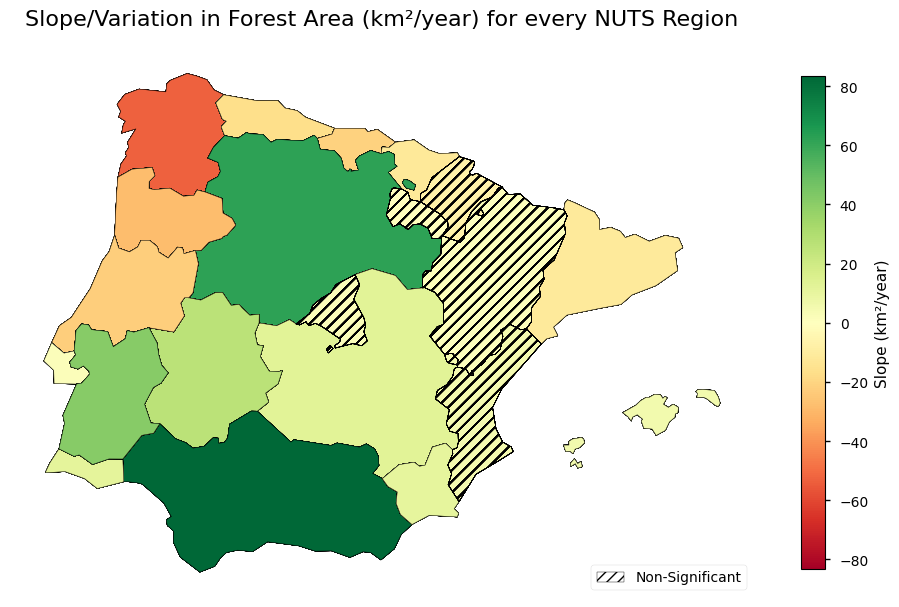

In [15]:
# Ensure results_df is a GeoDataFrame
if not isinstance(results_df, gpd.GeoDataFrame):
    results_df = gpd.GeoDataFrame(results_df, geometry=gpd.GeoSeries(results_df['geometry']), crs="EPSG:4326")

# Reproject to a projected CRS (EPSG:3035 is suitable for Europe)
results_df = results_df.to_crs("EPSG:3035")

# Check for invalid geometries
invalid_geometries = results_df[~results_df.is_valid]

#  Remove empty geometries
results_df = results_df[results_df.geometry.notnull() & ~results_df.is_empty]

# Check total bounds again after cleaning
bounds = results_df.total_bounds

#  Proceed with plotting if bounds are valid
if np.all(np.isfinite(bounds)):
    vmax = results_df["Slope"].abs().max()  # Symmetric vmax for color scale
    cmap = "RdYlGn"
    norm = colors.Normalize(vmin=-vmax, vmax=vmax)

    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot all regions with original colors
    results_df.plot(
        column="Slope",
        cmap=cmap,
        ax=ax,
        norm=norm,
        edgecolor="black",
        legend=True,
        legend_kwds={"label": "Slope (km²/year)", "shrink": 0.8},
    )

    # Overlay hatching for non-significant regions
    non_significant_df = results_df[results_df["P_Value"] >= 0.05]  # Adjust column name to match results_df
    non_significant_df.plot(
        ax=ax, facecolor="none", hatch="///", edgecolor="black"
    )

    # Create a proxy artist for the legend handle
    legend_handles = [
        Patch(facecolor="white", edgecolor="black", hatch="///", label="Non-Significant")
    ]

    # Add custom legend
    ax.legend(handles=legend_handles, loc="lower right", fontsize=10)

    # Turn off axis
    ax.axis("off")

    plt.title("Slope/Variation in Forest Area (km²/year) for every NUTS Region", fontsize=16)
    plt.show()


#### Map Analysis

**How to Interpret:**
The map above represents the slope of forest area variation (km2/year) across different NUTS regions of the Iberian Peninsula. The slope values indicate the rate of change in forest area, with positive values (yellow to green) representing forest expansion and negative values (yellow to red) representing forest loss.

**Analysis**

* The regions experiencing the greatest loss of forest area are also those with the highest forest cover, which remained largely unchanged in 2022.

* The regions with the highest increase in forest area are Andalusia and Castilla y León, although the percentage of total land covered by forests did not change significantly.

(code-section-4)=
### 4. Main Takeaways

**Afforestation Trends Observed**

- The analysis reveals a general increase in forest coverage from 1992 to 2022 across the Iberian Peninsula. However, the trends are highly variable, both temporally and spatially [[3]](https://doi.org/10.1016/j.scitotenv.2015.07.005).
- Regions like Galicia, Norte (Portugal), and Cantabria consistently show the highest forest coverage percentages (above 60%), with minor fluctuations over time. Galicia, for example, maintained a high but slightly decreasing forest percentage after the early 2000s [[4]](https://doi.org/10.1016/J.LANDUSEPOL.2018.06.054).
- In contrast, regions like Andalucía, Extremadura, and Comunidad Valenciana exhibit significantly lower forest coverage percentages (<30%), with minimal increases or stagnation over the years [[5]](https://doi.org/10.3390/LAND7030099).
- Regions such as País Vasco and Principado de Asturias experienced sharp declines around 1998–2000, as seen in the percentage difference plot, followed by recovery. These temporal disruptions highlight regional challenges, potentially linked to deforestation or data inconsistencies [[6]](https://doi.org/10.1007/s10113-018-1415-6).

**Spatial Distribution of Forest Coverage**

- Forest cover is predominantly concentrated in the northern and northwestern regions, such as Norte (PT), Galicia, Cantabria, and País Vasco, which maintained high forest percentages over the 30-year period [[4]](https://doi.org/10.1016/J.LANDUSEPOL.2018.06.054).
- Southern and eastern regions, such as Andalucía, Región de Murcia, and Extremadura, consistently lag behind in forest coverage, with slow progress over time. These areas may face climatic challenges like water scarcity or competing land uses, such as agriculture [[7]](https://doi.org/10.1016/J.PCE.2004.05.004).
- The maps of biennial forest area percentage changes (e.g., 1998–2000 and 2012–2014) show areas of strong growth interspersed with losses. Notably, periods of sharp negative changes (e.g., Cantabria in 2000) suggest localized disturbances that require further investigation [[6]](https://doi.org/10.1007/s10113-018-1415-6).

**Temporal Patterns of Forest Coverage and Change**

- The percentage difference plot reveals that the period between 1998 and 2004 was marked by significant volatility, with some regions experiencing sharp drops (e.g., Cantabria and País Vasco) and others showing recovery [[3]](https://doi.org/10.1016/j.scitotenv.2015.07.005).
- Post-2004, the year-over-year percentage differences stabilized across most regions, with fluctuations remaining within a narrow range (±1%). This stabilisation indicates a slower but steady afforestation trend in recent years [[4]](https://doi.org/10.1016/J.LANDUSEPOL.2018.06.054).
- Regions like Algarve and Castilla-La Mancha demonstrated slight positive trends over the last decade, indicating ongoing afforestation initiatives or natural regrowth [[5]](https://doi.org/10.3390/LAND7030099).

**Regional Outliers and Specific Trends**

- Regions such as Galicia and Cantabria show high initial forest coverage but slight declines in forest percentage post-2000, which could suggest saturation of available forested land or disturbances such as wildfires [[6]](https://doi.org/10.1007/s10113-018-1415-6).
- Conversely, Alentejo and Extremadura display a gradual increase in forest coverage, albeit starting from a much lower baseline, highlighting ongoing afforestation efforts in these areas [[7]](https://doi.org/10.1016/J.PCE.2004.05.004).
- Certain regions, like Cataluña and Castilla y León, display relative stability in forest coverage over the years, indicating a balance between afforestation and other land-use changes [[4]](https://doi.org/10.1016/J.LANDUSEPOL.2018.06.054). 


## ℹ️ If you want to know more

### Key Resources

* The CDS catalogue entry for the data used was [Land cover classification gridded maps from 1992 to present derived from satellite observations](https://cds.climate.copernicus.eu/datasets/satellite-land-cover?tab=overview)

* Product User Guide and Specification of the dataset [version 2.1](https://datastore.copernicus-climate.eu/documents/satellite-land-cover/D5.3.1_PUGS_ICDR_LC_v2.1.x_PRODUCTS_v1.1.pdf) and [version 2.0](https://datastore.copernicus-climate.eu/documents/satellite-land-cover/D3.3.11-v1.0_PUGS_CDR_LC-CCI_v2.0.7cds_Products_v1.0.1_APPROVED_Ver1.pdf) 

* [Eurostat NUTS](https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts) (Nomenclature of territorial units for statistics)

* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), c3s_eqc_automatic_quality_control, prepared by [BOpen](https://www.bopen.eu/)




### References

[[1]](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Forests,_forestry_and_logging) EUROSTAT: Forests, forestry and logging

[[2]](https://commission.europa.eu/document/cf3294e1-8358-4c93-8de4-3e1503b95201_en) New EU Forest Strategy for 2030

[[3]](https://doi.org/10.1016/j.scitotenv.2015.07.005) Buendia, C., Bussi, G., Tuset, J., Vericat, D., Sabater, S., Palau, A., & Batalla, R. (2016). Effects of afforestation on runoff and sediment load in an upland Mediterranean catchment. The Science of the Total Environment, 540, 144–157. 

[[4]](https://doi.org/10.1016/J.LANDUSEPOL.2018.06.054) Herguido Sevillano, E., Lavado Contador, J., Schnabel, S., Pulido, M., & Ibáñez, J. (2018). Using spatial models of temporal tree dynamics to evaluate the implementation of EU afforestation policies in rangelands of SW Spain. Land Use Policy, 77, 267–278. 

[[5]](https://doi.org/10.3390/LAND7030099) Fernández-Nogueira, D., & Corbelle-Rico, E. (2018). Land use changes in Iberian Peninsula 1990–2012. Land, 7(3), 99. 

[[6]](https://doi.org/10.1007/s10113-018-1415-6) Silva, J. M. N., Moreno, M., Le Page, Y., Oom, D., Bistinas, I., & Pereira, J. (2018). Spatiotemporal trends of area burnt in the Iberian Peninsula, 1975–2013. Regional Environmental Change, 19(2), 515–527. 

[[7]](https://doi.org/10.1016/J.PCE.2004.05.004) Gallart, F., & Llorens, P. (2004). Observations on land cover changes and water resources in the headwaters of the Ebro catchment, Iberian Peninsula. Physics and Chemistry of the Earth, 29(11–12), 769–773. 